In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import skbio
import scipy
import matplotlib
from collections import defaultdict
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap

%matplotlib inline
sns.set_style('white')
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 200

### Notes

- In this Jupyter notebook, I demonstrasted how I used Matplotlib to generate the strain sharing plot for detecting within-plate cross-contamination (i.e., Figure 2 in Lou et al., *Microbiome* 2023. "Using strain-resolved analysis to identify contamination in metagenomics data.")

### Load tables

In [2]:
ISdb=pd.read_csv('strain_sharing_plot_demonstration/sheets/StrainSharingDatasheet.csv')
ISdb

,infant1,infant2,sample1,sample2,NCBI_sample_code1,NCBI_sample_code2,column_distance_on_plate,physical_distance_on_plate,sample_pairs_v1,sample_pairs_v2,infant_pairs,sibling,name,popANI,percent_compared,conANI,coverage_overlap,completeness,contamination,strain_heterogeneity,compared_bases_count,consensus_SNPs,population_SNPs,genome,phylum,genus,species,name1,name2,plate_loc1,plate_loc2
0,#13,#21,#13D14,#21D36,L2_013_014G1,L2_021_036G1,3.0,4.242641,#13D14-vs-#21D36,#21D36-vs-#13D14,#13-vs-#21,No,Lactobacillus_paracasei_dasL2_013_015G1_metabat.metabat.11.fa.fa,1.000000,0.943935,0.998918,0.948338,98.91,0.00,0.00,2339093,2530,0,dasL2_013_015G1_metabat.metabat.11.fa.fa,Firmicutes,Lactobacillus,Lactobacillus paracasei,NIHL.delta.fasta-vs-L2_013_014G1.shrink.sort.bam,NIHL.delta.fasta-vs-L2_021_036G1.shrink.sort.bam,P1,P1
1,#13,#21,#13D15,#21D36,L2_013_015G1,L2_021_036G1,3.0,3.605551,#13D15-vs-#21D36,#21D36-vs-#13D15,#13-vs-#21,No,Lactobacillus_paracasei_dasL2_013_015G1_metabat.metabat.11.fa.fa,1.000000,0.944981,0.999029,0.948118,98.91,0.00,0.00,2341686,2273,0,dasL2_013_015G1_metabat.metabat.11.fa.fa,Firmicutes,Lactobacillus,Lactobacillus paracasei,NIHL.delta.fasta-vs-L2_013_015G1.shrink.sort.bam,NIHL.delta.fasta-vs-L2_021_036G1.shrink.sort.bam,P1,P1
2,#13,#21,#13D17,#21D36,L2_013_017G1,L2_021_036G1,3.0,3.162278,#13D17-vs-#21D36,#21D36-vs-#13D17,#13-vs-#21,No,Lactobacillus_paracasei_dasL2_013_015G1_metabat.metabat.11.fa.fa,1.000000,0.916019,0.999256,0.925470,98.91,0.00,0.00,2269918,1688,0,dasL2_013_015G1_metabat.metabat.11.fa.fa,Firmicutes,Lactobacillus,Lactobacillus paracasei,NIHL.delta.fasta-vs-L2_013_017G1.shrink.sort.bam,NIHL.delta.fasta-vs-L2_021_036G1.shrink.sort.bam,P1,P1
3,#19,#23,#19D61,#23D15,L2_019_061G1,L2_023_015G1,2.0,4.472136,#19D61-vs-#23D15,#23D15-vs-#19D61,#19-vs-#23,No,Clostridium_butyricum_dasL3_063_040G1_concoct_8.fa,0.999999,0.885981,0.999489,0.990941,99.19,0.00,0.00,3980572,2035,5,dasL3_063_040G1_concoct_8.fa,Firmicutes,Clostridium,Clostridium butyricum,NIHL.delta.fasta-vs-L2_019_061G1.shrink.sort.bam,NIHL.delta.fasta-vs-L2_023_015G1.shrink.sort.bam,P1,P1
4,#19,#23,#19D70,#23D15,L2_019_070G1,L2_023_015G1,2.0,3.605551,#19D70-vs-#23D15,#23D15-vs-#19D70,#19-vs-#23,No,Clostridium_butyricum_dasL3_063_040G1_concoct_8.fa,0.999999,0.885799,0.999525,0.992314,99.19,0.00,0.00,3979754,1892,5,dasL3_063_040G1_concoct_8.fa,Firmicutes,Clostridium,Clostridium butyricum,NIHL.delta.fasta-vs-L2_019_070G1.shrink.sort.bam,NIHL.delta.fasta-vs-L2_023_015G1.shrink.sort.bam,P1,P1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,#128,NC,#128D124,NC4,L3_128_124G1,L3_EC_002P2,0.0,1.000000,#128D124-vs-NC4,NC4-vs-#128D124,#128-vs-NC,No,Clostridioides_difficile_dasL3_069_000G1_maxbin2.maxbin.053.fasta.fa,0.999999,0.975728,0.999532,0.989827,98.75,0.08,0.00,4061717,1902,5,dasL3_069_000G1_maxbin2.maxbin.053.fasta.fa,Firmicutes,Clostridioides,Clostridioides difficile,NIHL.delta.fasta-vs-L3_128_124G1.shrink.sort.bam,NIHL.delta.fasta-vs-L3_EC_002P2.shrink.sort.bam,P4,P4
464,#128,NC,#128D124,NC4,L3_128_124G1,L3_EC_002P2,0.0,1.000000,#128D124-vs-NC4,NC4-vs-#128D124,#128-vs-NC,No,Flavonifractor_plautii_dasL1_007_000G1_concoct_30.fa,0.999999,0.526183,0.999255,0.698980,99.33,0.00,0.00,2002750,1493,3,dasL1_007_000G1_concoct_30.fa,Firmicutes,Flavonifractor,Flavonifractor plautii,NIHL.delta.fasta-vs-L3_128_124G1.shrink.sort.bam,NIHL.delta.fasta-vs-L3_EC_002P2.shrink.sort.bam,P4,P4
465,#128,NC,#128D124,NC4,L3_128_124G1,L3_EC_002P2,0.0,1.000000,#128D124-vs-NC4,NC4-vs-#128D124,#128-vs-NC,No,Bifidobacterium_longum_dasL2_013_245G1_maxbin2.maxbin.013.fasta.fa,0.999990,0.759924,0.998977,0.978243,99.92,0.35,33.33,1874492,1917,18,dasL2_013_245G1_maxbin2.maxbin.013.fasta.fa,Actinobacteria,Bifidobacterium,Bifidobacterium longum,NIHL.delta.fasta-vs-L3_128_124G1.shrink.sort.bam,NIHL.delta.fasta-vs-L3_EC_002P2.shrink.sort.bam,P4,P4
466,#128,NC,#128D124,NC4,L3_128_124G1,L3_EC_002P2,0.0,1.00

In [15]:
Mdb=pd.read_csv('case_study_I/NCBI_code_name2sample_name.csv')
Mdb

,NCBI_sample_code,sample_name,infant,DOL,location,extraction_plate,duplicated_sample
0,L2_037_047G1,#37D47,37,47,Gut,P1,No
1,L2_013_033G1,#13D33,13,33,Gut,P1,No
2,L2_013_371G1,#13D371,13,371,Gut,P1,No
3,L2_019_037G1,#19D37,19,37,Gut,P1,No
4,L2_021_096G1,#21D96,21,96,Gut,P1,No
...,...,...,...,...,...,...,...
389,L3_082_121G2,#82D121_dup,82,121,Gut,P5,Yes
390,L3_133_242G1,#133D242,133,242,Gut,P5,No
391,L3_132_122G1,#132D122,132,122,Gut,P5,No
392,L3_130_056G1,#130D56,130,56,Gut,P5,No


### looking for strain sharing count per plate per sample pairs

In [3]:
def count_strains(isdb,sample_pair_column):
    table = defaultdict(list)

    for sample_pair,spdb in isdb.groupby(sample_pair_column):
        num_shared_strains=len(spdb['name'].unique())

        plate_pair="{}-vs-{}".format(spdb.reset_index(drop=True).loc[0,'plate_loc1'],\
                                     spdb.reset_index(drop=True).loc[0,'plate_loc2'])

        table['sample1'].append(sample_pair.split('-vs-')[0])
        table['sample2'].append(sample_pair.split('-vs-')[1])
        table['sample_pairs'].append(sample_pair)
        table['num_shared_strains'].append(num_shared_strains)

    SPdb=pd.DataFrame(table).sort_values('num_shared_strains',ascending=False).reset_index(drop=True)
    return SPdb

In [6]:
SPdb=count_strains(ISdb,'sample_pairs_v1')
SPdb['extraction_plate']=SPdb['sample1'].map(dict(zip(ISdb['sample1'],ISdb['plate_loc1'])))
SPdb

,sample1,sample2,sample_pairs,num_shared_strains,extraction_plate
0,#98D4,#102M,#98D4-vs-#102M,16,P4
1,#114D237,#121D363,#114D237-vs-#121D363,12,P4
2,#114D237,#121D58,#114D237-vs-#121D58,11,P4
3,#114D237,#121D24,#114D237-vs-#121D24,10,P4
4,#114D237,#121D243,#114D237-vs-#121D243,10,P4
...,...,...,...,...,...
228,#58D72,#72D362,#58D72-vs-#72D362,1,P3
229,#58D72,#72D57,#58D72-vs-#72D57,1,P3
230,#58D72,#72D63,#58D72-vs-#72D63,1,P3
231,#60D144,#63D52,#60D144-vs-#63D52,1,P3


In [51]:
# Define function to add numbers to plate
def add_num_to_plate(pdb, sample_list):
    pdb_visual = pdb.copy()

    for i, row in pdb_visual.iterrows():
        for col in pdb_visual.columns:
            pdb_visual.at[i, col] = int(row[col] in sample_list)

    pdb_visual.fillna(value=np.nan, inplace=True)
    pdb_visual.index += 1 
    return pdb_visual

# Define function to add annotations to plate
def add_annot_plate(pdb, ldb):
    pdb_visual = pdb.copy()
    sample_list = ldb['sample_name'].tolist()
    pdb_visual = pdb_visual.apply(lambda x: [s if s in sample_list else 0 for s in x])
    pdb_visual.fillna(value=np.nan, inplace=True)
    pdb_visual.index += 1
    return pdb_visual

# Define function to create heatmap
def plot_heatmap(numered_plate, anno_plate, strain_sharing_sum_plate, sample_list):
    colors = plt.cm.turbo(np.linspace(0.08, 0.9, max(strain_sharing_sum_plate['num_shared_strains'].tolist())))
    
    fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(25, 10))

    sns.heatmap(
                numered_plate, 
                cmap=ListedColormap(['white']),
                annot=anno_plate.values, \
                fmt='', \
                cbar=False, \
                ax=ax, \
                linewidths=0.2,\
                linecolor='black',
                )
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    show_annot_array = anno_plate.values != 0
    for text, show_annot in zip(ax.texts, (element for row in show_annot_array for element in row)):
        text.set_visible(show_annot)

    sample2coor = {}
    for text in ax.texts:
        
        coords = [float(s.strip()) for s in str(text).strip('Text()').split(', ')[:2]]
        
        sample_name = str(text).strip('Text()').split(', ')[2].strip("''")
        
        if sample_name != '0':
            sample2coor[sample_name] = (coords[:2])
        else:
            continue
    
    for sample, (x, y) in sample2coor.items():
        facecolor = 'white' if sample not in sample_list else 'darkgray'
        circle = plt.Circle((x, y), 0.45, edgecolor='black', facecolor=facecolor)
        ax.set_aspect(1)
        ax.add_artist(circle)
        
    for iX, rowX in strain_sharing_sum_plate.iterrows():
        sample1 = rowX['sample1']
        sample2 = rowX['sample2']
        num_shared_strains = int(rowX['num_shared_strains'])
        plt.plot(
            [sample2coor[sample1][0], sample2coor[sample2][0]],
            [sample2coor[sample1][1], sample2coor[sample2][1]],
            linewidth=num_shared_strains/2,
            color=colors[num_shared_strains-1],
            marker='o',
            markersize=5,
        )

In [52]:
SPdb.head(2)

,sample1,sample2,sample_pairs,num_shared_strains,extraction_plate
0,#98D4,#102M,#98D4-vs-#102M,16,P4
1,#114D237,#121D363,#114D237-vs-#121D363,12,P4


P1


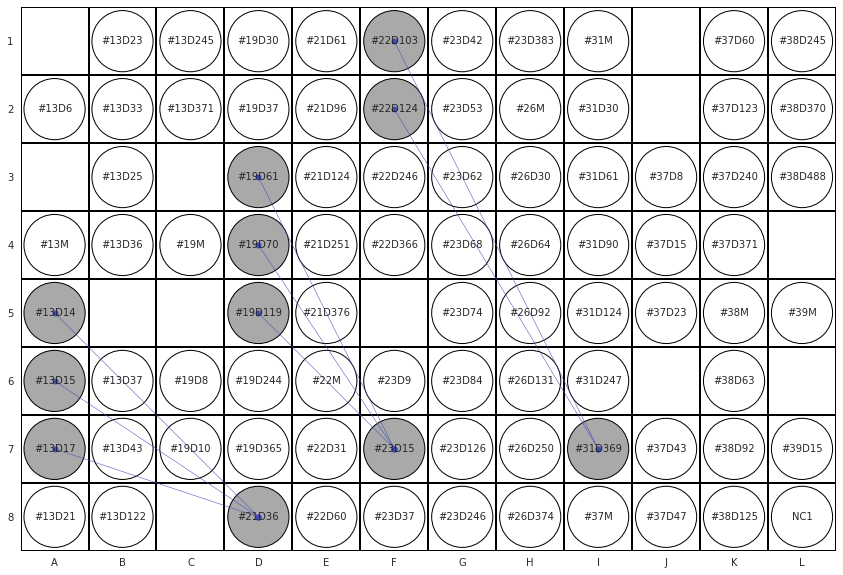

P2


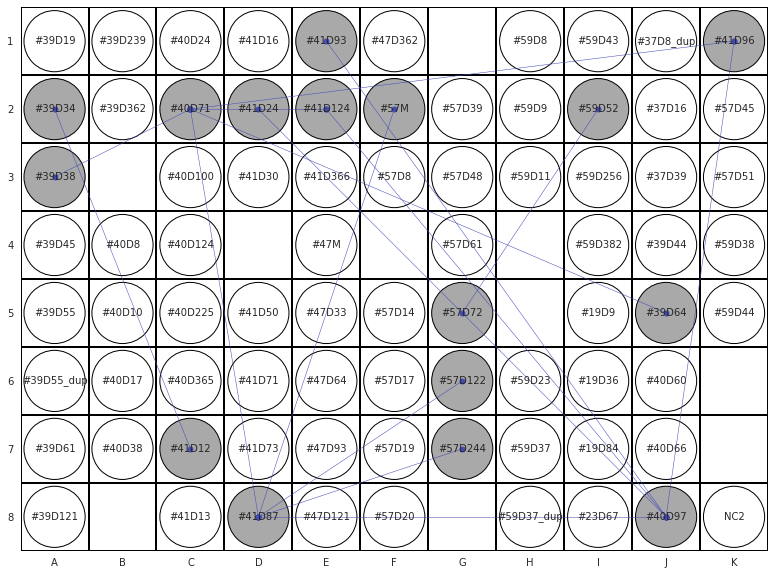

P3


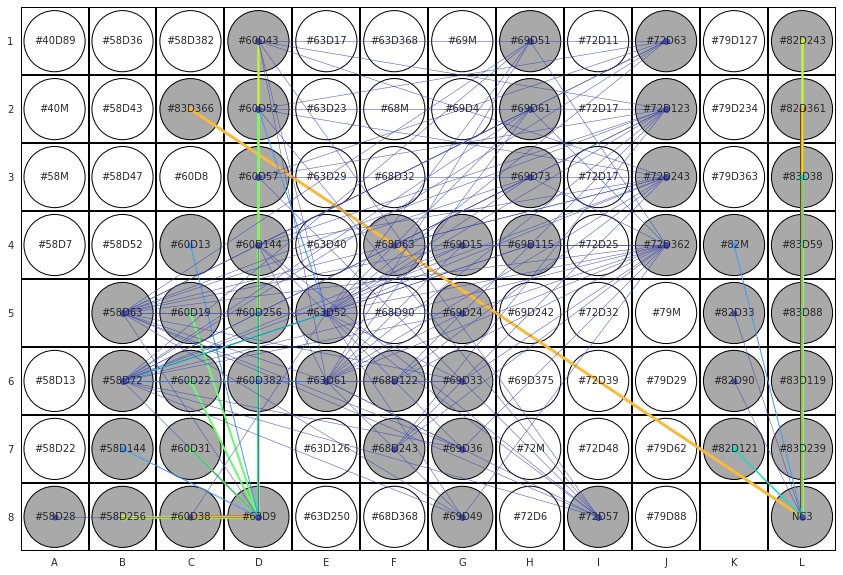

P4


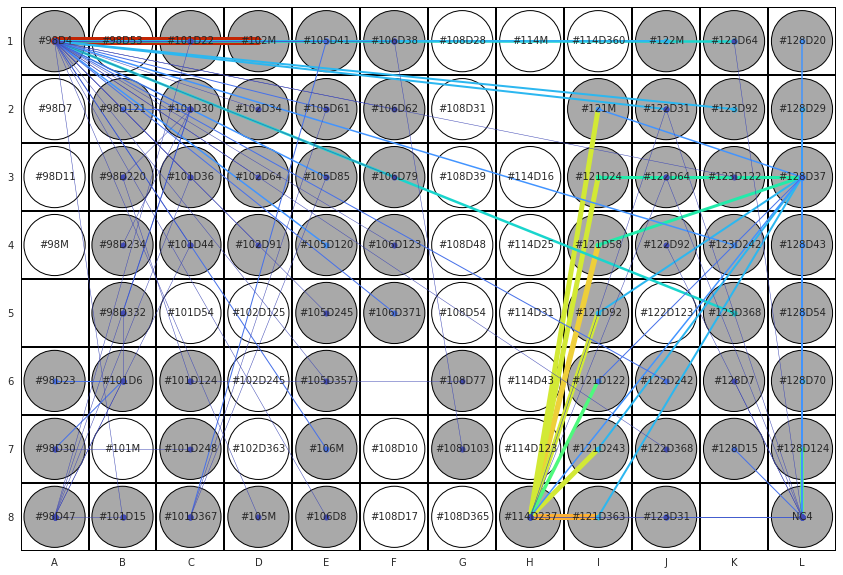

P5


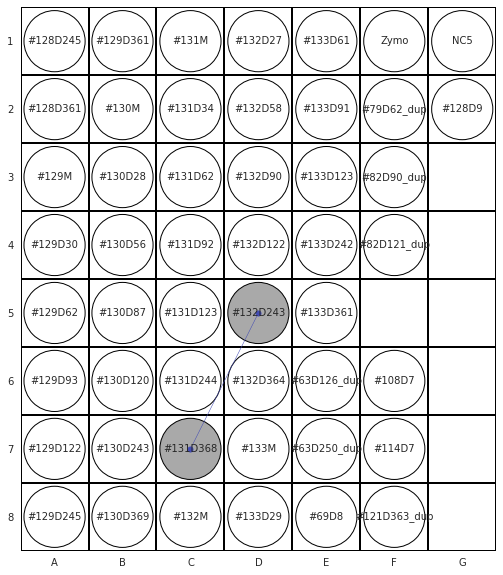

In [54]:
for plate,pdb in SPdb.groupby('extraction_plate'):
    Df=ISdb[ISdb['plate_loc1']==plate]
    sample_list=list(set(Df['sample1'].tolist()+Df['sample2'].tolist()))
    PlateDB=pd.read_csv('case_study_I/{}_plate_map.csv'.format(plate))
    
    plate_with_adjustion=add_num_to_plate(PlateDB,sample_list)
    plate_with_anno=add_annot_plate(PlateDB,Mdb)
    print(plate)
    plot_heatmap(plate_with_adjustion,plate_with_anno,pdb,sample_list)
    
    plt.show()